# Detecting Changeover with Machine Learning using NC Data and external Sensors

## 2-Phases Tuned

This notebook contains all the preliminary models used in the OBerA project.
It belongs to the article "Detecting Changeover with Machine Learning using NC Data and external Sensors" which can be found in Open Access by the following link: <https://www.mdpi.com/1424-8220/21/17/5896/htm>


## Packages used

Except for imblearn other packages used here are rather common for Anaconda distribution. Most of them are of the newest (or rather new) versions as of August 2021. You shall be able replicate the same results with the newest versions of these packages. However, below the version list of the packages used in the imports will be presented.

*For those interested, a 'requirements.txt' (generated by conda) file with all the packages used within the environment was also added to the project*


conda version : 4.10.3

python version : 3.9.6


pandas==1.4.1

numpy==1.22.2

matplotlib==3.5.1

seaborn==0.11.2

tensorflow==2.8.0

scikit-learn==1.0.2

imbalanced-learn==0.9.0

lightgbm==3.3.2

xgboost==1.5.2

catboost==1.0.4

# Imports


In [3]:
# Importing libraries
import pandas as pd #for working with dataframes
import numpy as np #for numerical and vector operations
import matplotlib as mpl #for visualization
import matplotlib.pyplot as plt #for visualization
import seaborn as sns #for visualization
import tensorflow as tf #for neural networks
from tensorflow import keras #for neural networks
import lightgbm as lgb #for light gradient boosting machine
import xgboost as xgb #for extreme gradient boosting 


# Metrics
from sklearn import metrics #metrics
from sklearn.metrics import classification_report #for F1 score and other metrics
from sklearn.metrics import f1_score #for F1 score specifically
from sklearn.metrics import matthews_corrcoef #for Matthews correlation coefficient (MCC)
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.metrics import roc_curve, roc_auc_score #ROC and AUC scores
from sklearn.metrics import ConfusionMatrixDisplay #for plotting confusion matrix

# Importing machine learning tools for preprocessing
from sklearn.model_selection import train_test_split #for splitting the data into training and test sets
from sklearn.preprocessing import StandardScaler #for feature scaling

# Models
from sklearn.tree import DecisionTreeClassifier #basic decision tree
from tensorflow.keras.optimizers import Adam #optimizer for neural networks
from imblearn.ensemble import BalancedRandomForestClassifier #balanced random forest classifier
from sklearn.ensemble import RandomForestClassifier #random forest classifier
from sklearn.ensemble import ExtraTreesClassifier #extra trees classifier
from sklearn.svm import SVC #support vector machine linear classifier
from catboost import CatBoostClassifier #cat boost classifier

# Function definition

Here we define a few functions that will be used to evaluate the models.


## ROC curve function
 

In [4]:
# Define the ROC curve function with graphical output

def plot_roc_curve(model):

    #setting up the parameters
    try:
        probs = model.predict(test_features)
        fpr, tpr, thresholds = roc_curve(test_labels, probs)
    except ValueError: #this is needed for Neural Network
        probs = np.argmax(model.predict(test_features, batch_size=1, verbose=0), axis=-1)
        fpr, tpr, thresholds = roc_curve(test_labels, probs)
        
    #plotting the ROC curve
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    #print AUC score
    print(f"AUC score: {roc_auc_score(test_labels, probs)}")

In [5]:
# Import data from csv
data = pd.read_csv("Data/Data_Detecting_Changeover.csv", sep= ',',header=0, index_col=0)
data.head()

,DateTime,ProgramStatus,ToolNumber,PocketTable,DriveStatus,DoorStatusTooling,OverrideFeed,FeedRate,SpindleSpeed,IndoorGPSx,IndoorGPSy,Phase,Phase_compressed,Production
0,2021-11-26 07:15:36,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,2000.0,-0.262,0.886,20,4,0
1,2021-11-26 07:15:38,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,1999.0,-0.251,0.840,20,4,0
2,2021-11-26 07:15:40,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,1999.0,-0.234,0.724,20,4,0
6358,2021-11-26 07:15:41,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,1999.0,-0.231,0.741,20,4,0
3,2021-11-26 07:15:42,2.0,1.0,1.0,1.0,0.0,43.0,3100.0,1999.0,-0.207,0.730,20,4,0


In [6]:
print(data.describe())

       ProgramStatus    ToolNumber   PocketTable   DriveStatus  \
count   21940.000000  21940.000000  21940.000000  21940.000000   
mean        1.439107     11.023473      4.698952      0.541796   
std         1.634662      8.434492      7.231461      0.498261   
min         0.000000      0.000000      0.000000      0.000000   
25%         0.000000      8.000000      0.000000      0.000000   
50%         2.000000      8.000000      1.000000      1.000000   
75%         2.000000     19.000000      8.000000      1.000000   
max         6.000000     32.000000     30.000000      1.000000   

       DoorStatusTooling  OverrideFeed      FeedRate  SpindleSpeed  \
count       21940.000000  21940.000000  21940.000000  21940.000000   
mean            0.039107     85.174878    607.645138   1828.052735   
std             0.193853     33.112375   3269.363502   2594.748294   
min             0.000000      0.000000 -32590.000000      0.000000   
25%             0.000000     84.000000      0.000000   

# Removing unnecessary columns

We need to ensure that our data contains entries useful for binary classification only. Everything else has to be discarded.


In [7]:
# Dropping the columns we do not need
df = data.copy()
df.pop('DateTime')
df.pop('Phase')
df.pop('Phase_compressed')
print(df)

       ProgramStatus  ToolNumber  PocketTable  DriveStatus  DoorStatusTooling  \
0                2.0         1.0          1.0          1.0                0.0   
1                2.0         1.0          1.0          1.0                0.0   
2                2.0         1.0          1.0          1.0                0.0   
6358             2.0         1.0          1.0          1.0                0.0   
3                2.0         1.0          1.0          1.0                0.0   
...              ...         ...          ...          ...                ...   
11002            0.0         8.0          8.0          0.0                0.0   
11003            0.0         8.0          8.0          0.0                0.0   
12252            0.0         8.0          8.0          0.0                0.0   
11004            0.0         8.0          8.0          0.0                0.0   
11005            0.0         8.0          8.0          0.0                0.0   

       OverrideFeed  FeedRa

# Data description


In [8]:
# Using the describe function to get 'raw' insights
df.describe()

,ProgramStatus,ToolNumber,PocketTable,DriveStatus,DoorStatusTooling,OverrideFeed,FeedRate,SpindleSpeed,IndoorGPSx,IndoorGPSy,Production
count,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000,21940.000000
mean,1.439107,11.023473,4.698952,0.541796,0.039107,85.174878,607.645138,1828.052735,-0.483395,1.451060,0.534549
std,1.634662,8.434492,7.231461,0.498261,0.193853,33.112375,3269.363502,2594.748294,0.288393,0.948068,0.498816
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-32590.000000,0.000000,-1.416000,-1.103000,0.000000
25%,0.000000,8.000000,0.000000,0.000000,0.000000,84.000000,0.000000,0.000000,-0.702000,0.622000,0.000000
50%,2.000000,8.000000,1.000000,1.000000,0.000000,100.000000,0.000000,0.000000,-0.486000,1.510000,1.000000
75%,2.000000,19.000000,8.000000,1.000000,0.000000,100.000000,310.000000,4599.000000,-0.270000,1.914000,1.000000
max,6.000000,32.000000,30.000000,1.000000,1.000000,150.000000,32732.000000,10046.000000,0.220000,5.104000,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

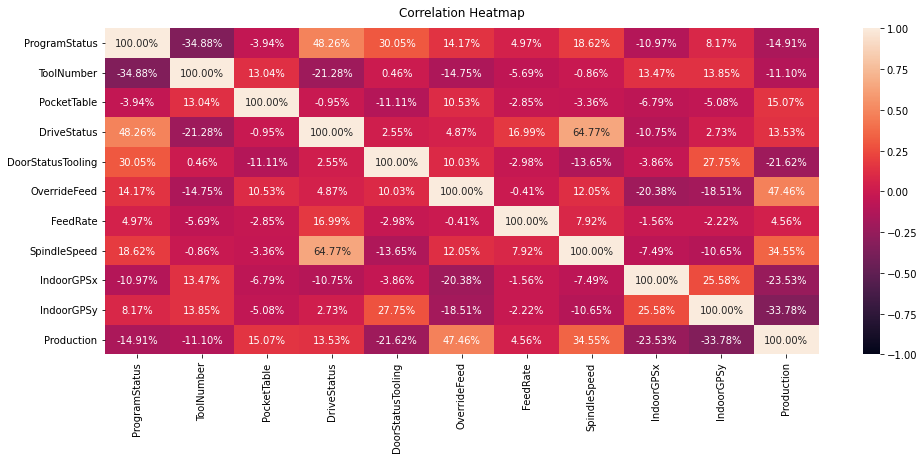

In [9]:
# Correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2%')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


# Data preparation


In [10]:
# Splitting the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# Using numpy to create arrays of lables and features
train_labels = np.array(train_df['Production'])
test_labels = np.array(test_df['Production'])
train_features = np.array(train_df.iloc[:, 0:10])
test_features = np.array(test_df.iloc[:, 0:10])

# Scaling the features using Standard Scaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Having a look at the results
print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)
print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (17552,)
Test labels shape: (4388,)
Training features shape: (17552, 10)
Test features shape: (4388, 10)


In [11]:
train_labels

array([1, 1, 1, ..., 0, 0, 0])

# Random Forest

Parameters didn't change after tuning

In [12]:
# Create a Random Forest classifier object with best parameters found via grid search
clf_RF = RandomForestClassifier(random_state=0)

# Train the Random Forest Classifier
clf_RF = clf_RF.fit(train_features, train_labels)

# Predict the response for the test dataset
y_pred_RF = clf_RF.predict(test_features)

In [13]:
# Get the metrics for the Random Tree
print(classification_report(test_labels,y_pred_RF))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2031
           1       0.99      1.00      1.00      2357

    accuracy                           0.99      4388
   macro avg       1.00      0.99      0.99      4388
weighted avg       0.99      0.99      0.99      4388



In [14]:
# Get macro average F1 score
f1_RF = f1_score(test_labels, y_pred_RF, average='macro')
f1_RF

0.994957808679614

In [15]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_RF = matthews_corrcoef(test_labels, y_pred_RF)
MCC_RF

0.9899172897426105

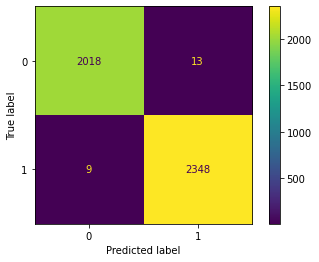

In [16]:
# Plot the confusion matrix for the Random Forest
cm=confusion_matrix(test_labels,y_pred_RF,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

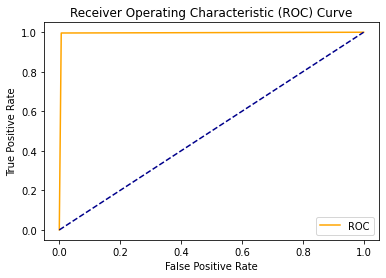

AUC score: 0.9948903994867838


In [17]:
# Plot the ROC curve and get the AUC score for the Random Forest
plot_roc_curve(clf_RF)

# Extra trees

Parameters didn't change after tuning


In [18]:
# Create an Extra Trees classifier object
clf_ET = ExtraTreesClassifier(n_jobs=-1,random_state=0)

# Train Extra Trees Classifier
clf_ET = clf_ET.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_ET = clf_ET.predict(test_features)

In [19]:
# Get the metrics for the Extra Trees
print(classification_report(test_labels,y_pred_ET))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2031
           1       1.00      1.00      1.00      2357

    accuracy                           1.00      4388
   macro avg       1.00      1.00      1.00      4388
weighted avg       1.00      1.00      1.00      4388



In [20]:
# Get macro average F1 score
f1_ET = f1_score(test_labels, y_pred_ET, average='macro')
f1_ET

0.995874570737866

In [21]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_ET = matthews_corrcoef(test_labels, y_pred_ET)
MCC_ET

0.9917508154088216

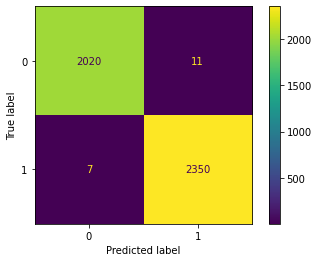

In [22]:
# Plot the confusion matrix for the Extra Trees
cm=confusion_matrix(test_labels,y_pred_ET,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

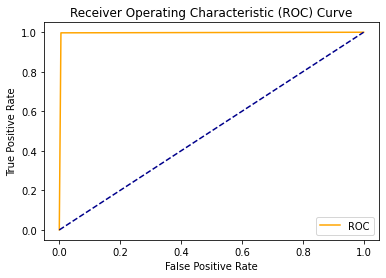

AUC score: 0.9958070359157287


In [23]:
# Plot the ROC curve and get the AUC score for the Decision Tree
plot_roc_curve(clf_ET)

# Cat Boost

In [24]:
clf_cat = CatBoostClassifier(iterations=260, depth=9, loss_function='Logloss', random_seed=0, 
                             random_strength=0.7,eta=0.3, sampling_frequency='PerTree')

clf_cat.fit(train_features, train_labels, verbose=False)

In [25]:
y_pred_cat = clf_cat.predict(test_features)
y_pred_cat

array([1, 1, 0, ..., 0, 0, 1])

In [26]:
print(classification_report(test_labels,y_pred_cat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2031
           1       1.00      1.00      1.00      2357

    accuracy                           1.00      4388
   macro avg       1.00      1.00      1.00      4388
weighted avg       1.00      1.00      1.00      4388



In [27]:
# Get macro average F1 score
f1_CAT= f1_score(test_labels, y_pred_cat, average='macro')
f1_CAT

0.9961046912528135

In [28]:
MCC_CAT = matthews_corrcoef(test_labels, y_pred_cat)
MCC_CAT

0.9922103238627762

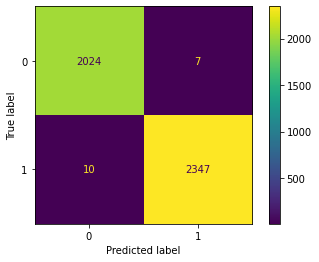

In [29]:
# Plot the confusion matrix for Catboost
cm=confusion_matrix(test_labels,y_pred_cat,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

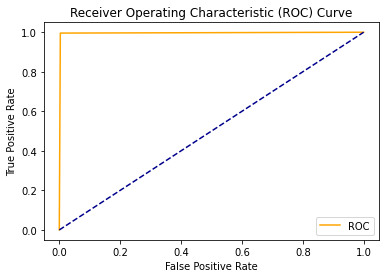

AUC score: 0.9961553702924985


In [30]:
# Plot the ROC curve and get the AUC score for Catboost
plot_roc_curve(clf_cat)

# LightGBM 

Parameter didn't change after tuning

In [31]:
clf_gbm=lgb.LGBMClassifier(random_state=0)
clf_gbm.fit(train_features,train_labels)

LGBMClassifier(random_state=0)

In [32]:
y_pred_gbm = clf_gbm.predict(test_features)
y_pred_gbm

array([1, 1, 0, ..., 0, 0, 1])

In [33]:
print(classification_report(test_labels,y_pred_gbm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2031
           1       1.00      1.00      1.00      2357

    accuracy                           1.00      4388
   macro avg       1.00      1.00      1.00      4388
weighted avg       1.00      1.00      1.00      4388



In [34]:
# Get macro average F1 score
f1_GBM = f1_score(test_labels, y_pred_gbm, average='macro')
f1_GBM

0.9954168178552755

In [35]:
MCC_GBM = matthews_corrcoef(test_labels, y_pred_gbm)
MCC_GBM

0.9908336357105509

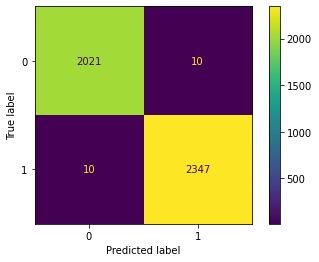

In [36]:
# Plot the confusion matrix for Light Gradient Boosting
cm=confusion_matrix(test_labels,y_pred_gbm,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

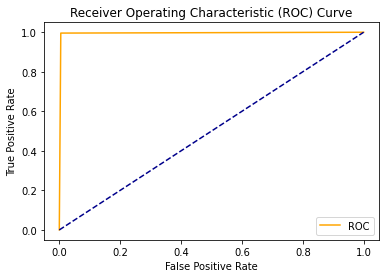

AUC score: 0.9954168178552755


In [37]:
# Plot the ROC curve and get the AUC score for Light Gradient Boosting
plot_roc_curve(clf_gbm)

## Extreme Gradient Boost


In [38]:
clf_xgb=xgb.XGBClassifier(objective='binary:logistic',colsample_bytree=0.7, learning_rate=0.4, max_depth=9, n_estimators=170, reg_alpha=0.005,
                          scale_pos_weight=3.3, subsample=0.9, random_state=0, verbosity=0);
clf_xgb.fit(train_features,train_labels);

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [39]:
y_pred_xgb = clf_xgb.predict(test_features)
y_pred_xgb

array([1, 1, 0, ..., 0, 0, 1])

In [40]:
print(classification_report(test_labels,y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2031
           1       1.00      1.00      1.00      2357

    accuracy                           1.00      4388
   macro avg       1.00      1.00      1.00      4388
weighted avg       1.00      1.00      1.00      4388



In [41]:
f1_XGB = f1_score(test_labels, y_pred_xgb, average='macro')
f1_XGB

0.9956455301057336

In [42]:
MCC_XGB = matthews_corrcoef(test_labels, y_pred_xgb)
MCC_XGB

0.9912920015160349

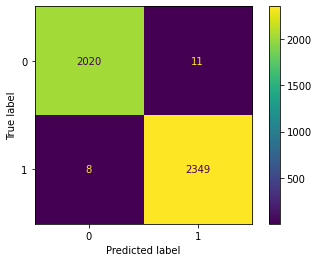

In [43]:
# Plot the confusion matrix for Extreme Gradient Boosting
cm=confusion_matrix(test_labels,y_pred_xgb,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

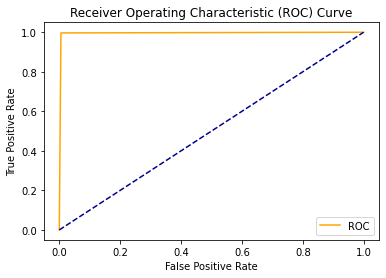

AUC score: 0.9955949018469973


In [44]:
# Plot the ROC curve and get the AUC score for Extreme Gradient Boosting
plot_roc_curve(clf_xgb)

# Comparison tables

Cells below contain code to create a nice-looking table which compares F1, AUC and MCC of all algorithms used in OBerA.


In [45]:
# Create a skeleton of the table
comp_table = pd.DataFrame(index=['Random Forest', 'Extra Trees','Catboost','LightGBM','XGBoost'], columns=['F1 score', 'AUC score', 'MCC'])

In [51]:
# Add values to the table
comp_table.iloc[0] = [f1_RF, roc_auc_score(test_labels, y_pred_RF), MCC_RF]
comp_table.iloc[1] = [f1_ET, roc_auc_score(test_labels, y_pred_ET), MCC_ET]
comp_table.iloc[2] = [f1_CAT, roc_auc_score(test_labels, y_pred_cat), MCC_CAT]
comp_table.iloc[3] = [f1_GBM, roc_auc_score(test_labels, y_pred_gbm), MCC_GBM]
comp_table.iloc[4] = [f1_XGB, roc_auc_score(test_labels, y_pred_xgb), MCC_XGB]

In [52]:
# Round all the values down to two digits
for i in range(len(comp_table)):
    comp_table.iloc[i] = comp_table.iloc[i].apply(lambda x: round(x, 2))

In [53]:
# Show the table
comp_table

,F1 score,AUC score,MCC
Random Forest,0.99,0.99,0.99
Extra Trees,1.0,1.0,0.99
Catboost,1.0,1.0,0.99
LightGBM,1.0,1.0,0.99
XGBoost,1.0,1.0,0.99


# Graphical comparison tables

Below are the graphs that compare all the models in a better, human readable way.


(0.0, 1.0, 0.0, 1.0)

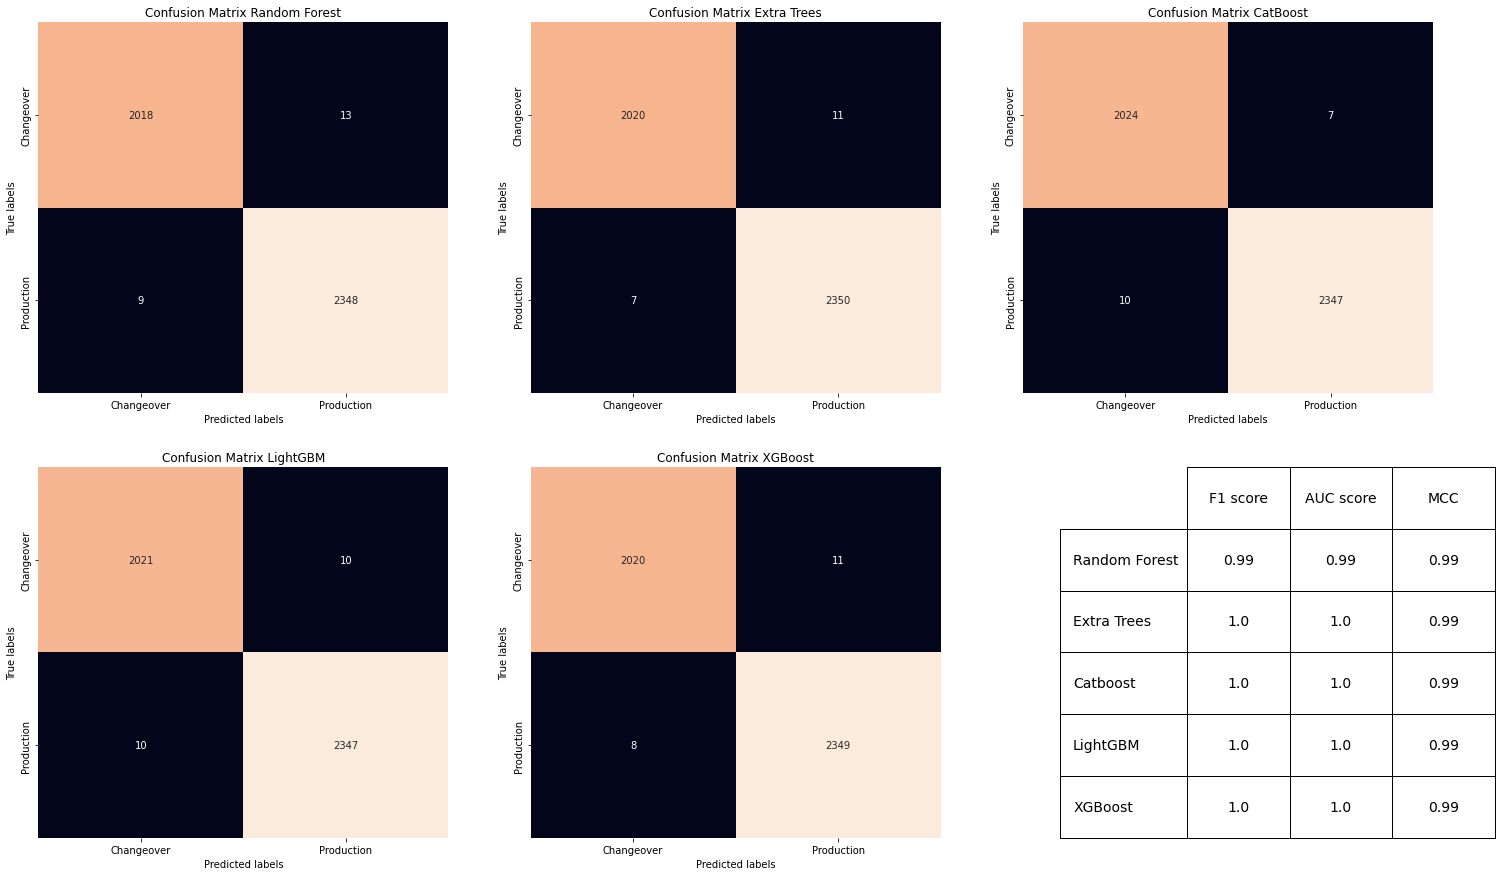

In [54]:
%%capture --no-display

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 15)) #creating a skeleton of the graph

labels = ['Changeover', 'Production'] #adding labels

sns.heatmap(confusion_matrix(test_labels, y_pred_RF), cbar=False, annot=True, fmt='g', ax=axs[0,0]) #adding Decision Tree to subplot 0,0
axs[0,0].set_title('Confusion Matrix Random Forest')

sns.heatmap(confusion_matrix(test_labels, y_pred_ET), cbar=False, annot=True, fmt='g', ax=axs[0,1]) #adding Neural Network to subplot 0,1
axs[0,1].set_title('Confusion Matrix Extra Trees')

sns.heatmap(confusion_matrix(test_labels, y_pred_cat), cbar=False, annot=True, fmt='g', ax=axs[0,2])#adding Balanced Random forest to subplot 0,2
axs[0,2].set_title('Confusion Matrix CatBoost')

sns.heatmap(confusion_matrix(test_labels, y_pred_gbm), cbar=False, annot=True, fmt='g', ax=axs[1,0])#adding Random Forest to subplot 1,0
axs[1,0].set_title('Confusion Matrix LightGBM')

sns.heatmap(confusion_matrix(test_labels, y_pred_xgb), cbar=False, annot=True, fmt='g', ax=axs[1,1])#adding SVC to subplot 1,1
axs[1,1].set_title('Confusion Matrix XGBoost')

for i in range(0,3): #iterating through our graphs to give a label to each
    axs[0,i].set(xlabel='Predicted labels')
    axs[0,i].set(ylabel='True labels')
    axs[0,i].xaxis.set_ticklabels(['Changeover', 'Production'])
    axs[0,i].yaxis.set_ticklabels(['Changeover', 'Production'], va='center')
    axs[1,i].set(xlabel='Predicted labels')
    axs[1,i].set(ylabel='True labels')
    axs[1,i].xaxis.set_ticklabels(['Changeover', 'Production'])
    axs[1,i].yaxis.set_ticklabels(['Changeover', 'Production'], va='center')

#fig.delaxes(axs[1,2]) #this line can be used to delete the unnecessary subplot from the entire plot

# Add our table with metrics from before to the graph
table = axs[1,2].table(cellText=comp_table.values,
          colLabels=comp_table.columns,
          rowLabels=comp_table.index,
          loc="lower right",
          cellLoc='center',
          bbox=[0.4, 0, 0.75, 1],
          fontsize=64).set_fontsize(14)

plt.axis('off')